<a href="https://colab.research.google.com/github/EricRibeiroAlves/Interacao-Humano-Robo/blob/main/%5BAP_T%5D_Eric_Modelo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Legenda**:
- $dt$: Passo de tempo (incremento de tempo entre as amostras).
- $t$: Tempo total (ou carimbo de tempo) da amostra.
- $\frac{d\tau_{r}}{dt}$: Derivada do torque do robô (variação do torque com o tempo).[R_d_T]
- $\tau_{r}$: Torque do robô [R_T].
- $S_Fx$: Sensor de torque Tx [R_Fx].
- $\omega_{l}$: Velocidade da coroa [R_w_l].
- $\theta_{l}$: Ângulo da coroa [R_t_l].
- $\theta_{m}$: Ângulo do motor [R_t_m].
- $\omega_{h}$: Velocidade da pessoa [R_w_p].
- $\theta_{h}$: Ângulo da pessoa [R_t_p].
- $∫e(Interacao).dt$: Integral do erro de torque [R_i_T_e].
- $U(x)$: Sinal de controle [R_u].
- $\tau^{d}_{r}$: Torque desejado do robô [R_T_d].
- $\tau_{i}$: Torque de interação [R_T_i].
- $\frac{d\omega_{l}}{dt}$: Derivada da velocidade da coroa  (variação da velocidade da coroa com o tempo). [R_d_w_l]
- $phase$: Fase do movimento ou do ciclo (possivelmente relacionada à fase da marcha).
- $\theta_{m, L}$: Ângulo do motor na perna esquerda .[L_t_m]
- $\theta_{l, L}$: Ângulo da coroa na perna esquerda .[L_t_l]
- $L_u$: Sinal de controle aplicado ao lado esquerdo.
- $\tau_{r, L}$: Torque real no lado esquerdo .[L_T_r]
- $\tau^{d}_{r, L}$: Torque desejado no lado esquerdo . [L_T_d]

# Bibliotecas

In [7]:
# Trato dos dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Libs p/ Modelo Deep LTSM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1º Passo: Montar o Drive e carregar o dataset


In [8]:
drive.mount('/content/drive')
t1_markov = "drive/MyDrive/last_data_MarkovMao 1.dat"
head_markov = ['dt', 't', 'R_d_T', 'R_T', 'R_Fx', 'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p',
               'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m', 'R_d_w_l', 'phase', 'L_t_m',
               'L_t_l', 'L_u', 'L_T_r', 'L_T_d']
pd.set_option('display.float_format', lambda x: '%.10f' % x)
markov_t1 = pd.read_table(t1_markov, header=None, names=head_markov, index_col=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2º Passo: Cálculo do torque de interação τ_i

In [9]:
Ka = 200  # Rigidez do acessório
Ba = 10   # Amortecimento do acessório
markov_t1['tau_i'] = Ka * (markov_t1['R_t_p'] - markov_t1['R_t_l']) + Ba * (markov_t1['R_w_p'] - markov_t1['R_w_l'])
markov_t1['d_tau_i'] = np.gradient(markov_t1['tau_i'])

# 3º Passo: Separação e Normalização dos dados


In [26]:
dataset = markov_t1.copy()
X = dataset[['tau_i', 'd_tau_i', 'phase']].iloc[1450:]
y = dataset[['R_T']].iloc[1450:]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 4º Passo: Criar sequências de dados para LSTM

In [27]:
timesteps = 420  # Ajustar conforme a análise
n_features = X_scaled.shape[1]

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_scaled, y_scaled, timesteps)
print("Forma dos dados de entrada para LSTM:", X_train.shape)
print("Forma dos dados de saída:", y_train.shape)

Forma dos dados de entrada para LSTM: (10129, 420, 3)
Forma dos dados de saída: (10129, 1)


# 5º Passo: Definição do Modelo LSTM otimizado

In [28]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(timesteps, n_features)))
model.add(Dropout(0.2))  # Dropout reduzido para 20%

model.add(LSTM(64, return_sequences=True))  # Reduzido para 64 neurônios
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences=False))  # Camada final com 32 unidades
model.add(Dropout(0.2))

model.add(Dense(1))  # Saída de um único valor (tau_r)

# Compilar o modelo com Huber loss e Adam com learning rate ajustado
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=Huber(), metrics=['MAE', 'MSE'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 6º Passo: Treinamento do Modelo

In [29]:
history = model.fit(X_train, y_train, epochs=8, batch_size=64, validation_split=0.2)

Epoch 1/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - MAE: 0.1631 - MSE: 0.0453 - loss: 0.0226 - val_MAE: 0.0618 - val_MSE: 0.0058 - val_loss: 0.0029
Epoch 2/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - MAE: 0.0821 - MSE: 0.0111 - loss: 0.0055 - val_MAE: 0.0508 - val_MSE: 0.0040 - val_loss: 0.0020
Epoch 3/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - MAE: 0.0709 - MSE: 0.0085 - loss: 0.0042 - val_MAE: 0.0497 - val_MSE: 0.0037 - val_loss: 0.0018
Epoch 4/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - MAE: 0.0684 - MSE: 0.0080 - loss: 0.0040 - val_MAE: 0.0435 - val_MSE: 0.0032 - val_loss: 0.0016
Epoch 5/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - MAE: 0.0639 - MSE: 0.0070 - loss: 0.0035 - val_MAE: 0.0517 - val_MSE: 0.0043 - val_loss: 0.0022
Epoch 6/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - MAE: 0.0654 - MSE: 0.0074 - loss: 0.0037 - val_MAE: 0.0496 - val_MSE: 0.0040 - val_loss: 0.0020
Epoch 7/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - MAE: 0.0629 - MSE: 0.0068 - loss: 0.0034 - val

# 7º Passo: Avaliação e Previsão

In [31]:
y_pred_scaled = model.predict(X_train)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_train_rescaled = scaler_y.inverse_transform(y_train)

# Métricas adicionais
r2 = r2_score(y_train_rescaled, y_pred)
mae = mean_absolute_error(y_train_rescaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_pred))

print(f'R²: {r2}')
print(f'MAE: {mae:.4f} Nm')
print(f'RMSE: {rmse:.4f} Nm')

317/317 ━━━━━━━━━━━━━━━━━━━━ 111s 347ms/step
R²: 0.8301391558651066
MAE: 0.9295 Nm
RMSE: 1.2364 Nm


# 8º Passo: Visualização das perdas (train vs validation)

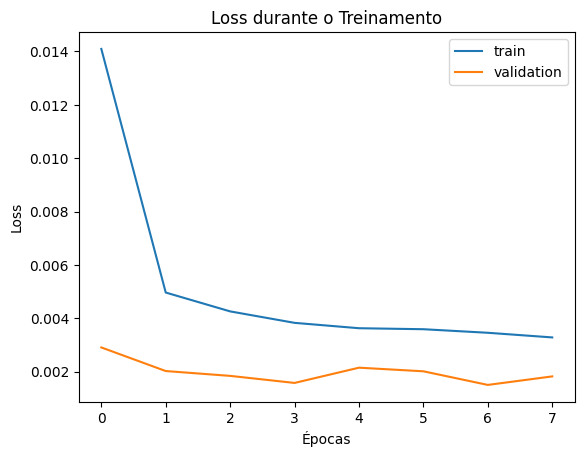

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.show()

# 9º Passo: Gráfico comparativo entre valores reais e previsões

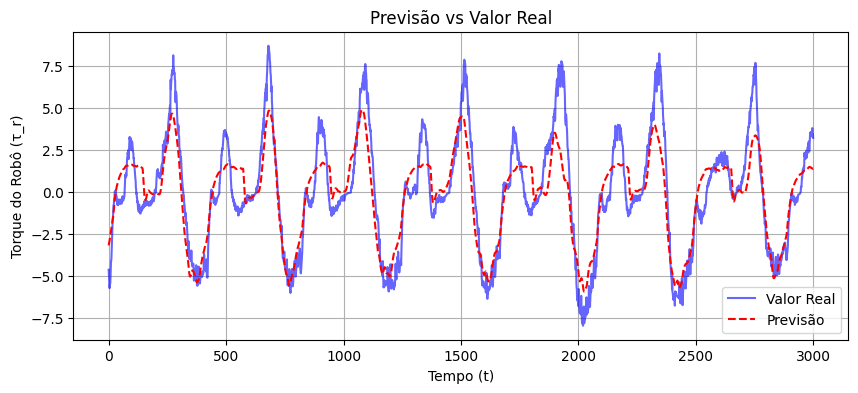

In [33]:
def plot_predictions(y_true, y_pred, title='Previsão vs Valor Real'):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.flatten(), label='Valor Real', color='blue', alpha=0.6)
    plt.plot(y_pred.flatten(), label='Previsão', color='red', linestyle='--', alpha=1)
    plt.title(title)
    plt.xlabel('Tempo (t)')
    plt.ylabel('Torque do Robô (τ_r)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exibir previsões vs valores reais para uma parte do dataset
plot_predictions(y_train_rescaled[:3000], y_pred[:3000])
